___
# Loading the data and libraries
___

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import warnings

while any(marker in os.getcwd() for marker in ['workspace_p3']):
    os.chdir("..")

sys.path.append('classes_and_functions_p3')

current_directory = os.getcwd()
current_directory

'c:\\Users\\barto\\Desktop\\Repos\\MachineLearning\\Project3'

In [45]:
import itertools

# Importing external packages
import pandas as pd
import numpy as np
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import accuracy_score, classification_report, matthews_corrcoef
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    VotingClassifier,
    AdaBoostClassifier,
    StackingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
import xgboost as xgb

# Importing custom-made functions and classes
from classes_and_functions_p3.custom_functions_classes_p3 import (
    DropColumnTransformer,
    CustomOrdinalEncoder,
    calculate_classification_metrics,
    aggregate_metrics_and_create_heatmaps_classification,
)

In [3]:
raw_data = pd.read_csv('attachments_p3/Data_set_task_3.csv')
raw_data

,Unnamed: 0.1,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,0,147.32.80.9,147.32.84.165,4,2,134,558,1.312967e+09,1.312967e+09,...,207900.070205,0.885171,0.205123,0.417904,NaN,4248.583372,4544.559854,0.564213,0.003325,neris
1,1,1,147.32.84.255,147.32.84.165,38,0,2476,0,1.312967e+09,1.312967e+09,...,5314.872532,0.038851,0.241710,0.223803,-1.333903,3.640725,0.786195,-0.830029,0.046606,clear
2,2,2,147.32.84.255,147.32.84.165,6,0,1160,0,1.312967e+09,1.312967e+09,...,-271216.457937,0.010243,0.393857,0.271931,NaN,214.629001,1171.605316,-0.489713,0.011965,clear
3,3,3,147.32.84.165.,60.190.222.139,4,0,249,0,1.312967e+09,1.312967e+09,...,-1060.499747,0.006667,0.407122,0.273574,-0.362061,1.505125,2.539462,-0.400313,0.010620,clear
4,4,4,60.190.222.139.,147.32.84.165,10,0,138,0,1.312967e+09,1.312967e+09,...,-4837.676869,0.187056,0.482592,0.285750,-0.098411,1.314013,2.857491,0.565604,0.021624,clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176635,11618,11618,64.142.97.114.,147.32.84.165,2,0,0,0,1.313558e+09,1.313558e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176636,11619,11619,147.32.84.165.,95.130.170.231,1,0,0,0,1.313563e+09,1.313563e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176637,11620,11620,95.130.170.231.,147.32.84.165,2,0,0,0,1.313563e+09,1.313563e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176638,11621,11621,147.32.84.165.,199.59.164.114,2,0,0,0,1.313565e+09,1.313565e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear


---
# ***EDA***
---

In [9]:
raw_data.dtypes

Unnamed: 0.1            int64
Unnamed: 0              int64
DST_IP                 object
SRC_IP                 object
PACKETS                 int64
                       ...   
SPECTRAL_CREST        float64
SPECTRAL_FLUX         float64
SPECTRAL_BANDWIDTH    float64
PERIODICITY_SCDF      float64
LABEL                  object
Length: 85, dtype: object

In [7]:
print(raw_data.columns, '\n', len(raw_data.columns))

Index(['Unnamed: 0.1', 'Unnamed: 0', 'DST_IP', 'SRC_IP', 'PACKETS',
       'PACKETS_REV', 'BYTES', 'BYTES_REV', 'TIME_FIRST', 'TIME_LAST',
       'DST_PORT', 'SRC_PORT', 'MEAN', 'MEDIAN', 'STDEV', 'VAR', 'BURSTINESS',
       'Q1', 'Q3', 'MIN', 'MAX', 'MIN_MINUS_MAX', 'MODE',
       'COEFFICIENT_OF_VARIATION', 'AVERAGE_DISPERSION', 'PERCENT_DEVIATION',
       'ROOT_MEAN_SQUARE', 'PERCENT_BELOW_MEAN', 'PERCENT_ABOVE_MEAN',
       'PEARSON_SK1_SKEWNESS', 'PEARSON_SK2_SKEWNESS', 'FISHER_MI_3_SKEWNESS',
       'FISHER_PEARSON_g1_SKEWNESS', 'FISHER_PEARSON_G1_SKEWNESS',
       'GALTON_SKEWNESS', 'KURTOSIS', 'ENTROPY', 'SCALED_ENTROPY',
       'HURST_EXPONENT', 'BENFORD_LAW_PRESENTED', 'P_BENFORD',
       'NORMAL_DISTRIBUTION', 'CNT_DISTRIBUTION', 'TIME_DISTRIBUTION',
       'AREA_VALUES_DISTRIBUTION', 'MEAN_SCALED_TIME', 'MEDIAN_SCALED_TIME',
       'Q1_SCALED_TIME', 'Q3_SCALED_TIME', 'DURATION', 'MEAN_DIFFTIMES',
       'MEDIAN_DIFFTIMES', 'MIN_DIFFTIMES', 'MAX_DIFFTIMES',
       'MEAN_SCAL

In [90]:
raw_data['LABEL'].unique()

array(['neris', 'clear', 'rbot', 'fast_flux', 'donbot', 'qvod'],
      dtype=object)

In [18]:
raw_data.dtypes[raw_data.dtypes == object]

DST_IP    object
SRC_IP    object
LABEL     object
dtype: object

In [21]:
len(raw_data['DST_IP'].unique())

36781

Since there is so many unique types, it would be more beneficial to use Label/Ordinar encoder rather than OneHot, as there would be too many new columns. 

I do not like being cursed by dimensions or something.

In [38]:
raw_data[raw_data['Unnamed: 0'] == raw_data['Unnamed: 0.1']]

,Unnamed: 0.1,Unnamed: 0,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,...,SPECTRAL_SKEWNESS,SPECTRAL_ROLLOFF,SPECTRAL_CENTROID,SPECTRAL_SPREAD,SPECTRAL_SLOPE,SPECTRAL_CREST,SPECTRAL_FLUX,SPECTRAL_BANDWIDTH,PERIODICITY_SCDF,LABEL
0,0,0,7661,2795,4,2,134,558,1.312967e+09,1.312967e+09,...,207900.070205,0.885171,0.205123,0.417904,NaN,4248.583372,4544.559854,0.564213,0.003325,neris
1,1,1,7880,2795,38,0,2476,0,1.312967e+09,1.312967e+09,...,5314.872532,0.038851,0.241710,0.223803,-1.333903,3.640725,0.786195,-0.830029,0.046606,clear
2,2,2,7880,2795,6,0,1160,0,1.312967e+09,1.312967e+09,...,-271216.457937,0.010243,0.393857,0.271931,NaN,214.629001,1171.605316,-0.489713,0.011965,clear
3,3,3,7866,4829,4,0,249,0,1.312967e+09,1.312967e+09,...,-1060.499747,0.006667,0.407122,0.273574,-0.362061,1.505125,2.539462,-0.400313,0.010620,clear
4,4,4,33865,2795,10,0,138,0,1.312967e+09,1.312967e+09,...,-4837.676869,0.187056,0.482592,0.285750,-0.098411,1.314013,2.857491,0.565604,0.021624,clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176635,11618,11618,34188,2795,2,0,0,0,1.313558e+09,1.313558e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176636,11619,11619,7866,5113,1,0,0,0,1.313563e+09,1.313563e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176637,11620,11620,36640,2795,2,0,0,0,1.313563e+09,1.313563e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear
176638,11621,11621,7866,2954,2,0,0,0,1.313565e+09,1.313565e+09,...,NaN,0.006667,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,clear


I think I will get rid of these columns, as they are weird wrong indexing and they a copypaste of each other.

In [4]:
nulls_percentage = raw_data.isnull().mean() * 100
print('Percentage of nulls in each feature')
nulls_percentage

Percentage of nulls in each feature


Unnamed: 0.1           0.000000
Unnamed: 0             0.000000
DST_IP                 0.000000
SRC_IP                 0.000000
PACKETS                0.000000
                        ...    
SPECTRAL_CREST        75.588202
SPECTRAL_FLUX         75.588202
SPECTRAL_BANDWIDTH     0.000000
PERIODICITY_SCDF      75.588202
LABEL                  0.000000
Length: 85, dtype: float64

In [5]:
nulls_percentage[nulls_percentage>50]

MIN_POWER            75.588202
MAX_POWER            75.588202
MIN_POWER_FREQ       75.588202
MAX_POWER_FREQ       75.588202
POWER_MEAN           75.588202
POWER_STD            75.588202
SPECTRAL_ENERGY      75.588202
SPECTRAL_ENTROPY     84.326313
SPECTRAL_KURTOSIS    75.588202
SPECTRAL_SKEWNESS    75.588202
SPECTRAL_CENTROID    77.732111
SPECTRAL_SPREAD      79.586164
SPECTRAL_SLOPE       85.224185
SPECTRAL_CREST       75.588202
SPECTRAL_FLUX        75.588202
PERIODICITY_SCDF     75.588202
dtype: float64

In [6]:
nulls_to_get_rid_of = nulls_percentage[nulls_percentage>50]
len(nulls_to_get_rid_of)

16

Maybe we should consider getting rid of these columns (Spoiler: I will get rid of them).

In [82]:
nulls_percentage[nulls_percentage>0]

NORMAL_DISTRIBUTION          0.058877
TIME_DISTRIBUTION            1.807631
AREA_VALUES_DISTRIBUTION     0.007926
MEAN_DIFFTIMES               1.807631
MEDIAN_DIFFTIMES             1.807631
MIN_DIFFTIMES                1.807631
MAX_DIFFTIMES                1.807631
MEAN_SCALED_DIFFTIMES        1.808764
MIN_POWER                   75.588202
MAX_POWER                   75.588202
MIN_POWER_FREQ              75.588202
MAX_POWER_FREQ              75.588202
POWER_MEAN                  75.588202
POWER_STD                   75.588202
SPECTRAL_ENERGY             75.588202
SPECTRAL_ENTROPY            84.326313
SPECTRAL_KURTOSIS           75.588202
SPECTRAL_SKEWNESS           75.588202
SPECTRAL_CENTROID           77.732111
SPECTRAL_SPREAD             79.586164
SPECTRAL_SLOPE              85.224185
SPECTRAL_CREST              75.588202
SPECTRAL_FLUX               75.588202
PERIODICITY_SCDF            75.588202
dtype: float64

In [84]:
raw_data[['NORMAL_DISTRIBUTION', 'TIME_DISTRIBUTION', 'AREA_VALUES_DISTRIBUTION', 'MEAN_DIFFTIMES', 'MEDIAN_DIFFTIMES', 'MIN_DIFFTIMES', 'MAX_DIFFTIMES', 'MEAN_SCALED_DIFFTIMES']]

,NORMAL_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES
0,0.0,0.497004,0.416667,0.455277,0.000619,0.000006,2.254977,0.201899
1,0.0,0.428112,0.828125,0.336548,0.000015,0.000000,1.763265,0.190866
2,0.0,0.666641,0.750000,0.802649,0.000012,0.000011,4.012922,0.200016
3,0.0,0.339969,0.791667,0.849160,0.305781,0.305220,1.936479,0.438507
4,0.0,0.283852,0.708333,0.330347,0.000010,0.000007,2.353862,0.140343
...,...,...,...,...,...,...,...,...
176635,0.0,0.500000,0.875000,0.000010,0.000010,0.000010,0.000010,1.000000
176636,0.0,NaN,0.875000,NaN,NaN,NaN,NaN,NaN
176637,0.0,0.500000,0.875000,0.000009,0.000009,0.000009,0.000009,1.000000
176638,0.0,0.500000,0.875000,0.000033,0.000033,0.000033,0.000033,1.000000


In [91]:
nans_data = raw_data[raw_data['TIME_DISTRIBUTION'].isna()]
nans_data[['NORMAL_DISTRIBUTION', 'TIME_DISTRIBUTION', 'AREA_VALUES_DISTRIBUTION', 'MEAN_DIFFTIMES', 'MEDIAN_DIFFTIMES', 'MIN_DIFFTIMES', 'MAX_DIFFTIMES', 'MEAN_SCALED_DIFFTIMES']]

,NORMAL_DISTRIBUTION,TIME_DISTRIBUTION,AREA_VALUES_DISTRIBUTION,MEAN_DIFFTIMES,MEDIAN_DIFFTIMES,MIN_DIFFTIMES,MAX_DIFFTIMES,MEAN_SCALED_DIFFTIMES
10,0.0,NaN,0.875,NaN,NaN,NaN,NaN,NaN
15,0.0,NaN,0.875,NaN,NaN,NaN,NaN,NaN
17,0.0,NaN,0.875,NaN,NaN,NaN,NaN,NaN
21,0.0,NaN,0.875,NaN,NaN,NaN,NaN,NaN
31,0.0,NaN,0.875,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
176337,0.0,NaN,0.875,NaN,NaN,NaN,NaN,NaN
176624,0.0,NaN,0.875,NaN,NaN,NaN,NaN,NaN
176627,0.0,NaN,0.875,NaN,NaN,NaN,NaN,NaN
176634,0.0,NaN,0.875,NaN,NaN,NaN,NaN,NaN


I think it might not be a bad idea to get rid of rows with this many missing values. It is only 3200. And it would not be easy to impute them with a good explanation. After getting rid of them I may use many more models that are NaN sensitive.

---
# ***Raw Classifier***
---

In [42]:
label_encoder = LabelEncoder()
raw_data['DST_IP'] = label_encoder.fit_transform(raw_data['DST_IP'])
raw_data['SRC_IP'] = label_encoder.fit_transform(raw_data['SRC_IP'])

I encoded roughly those two features, for XGB to work.

In [43]:
X = raw_data.drop(columns=["LABEL"])
y = raw_data["LABEL"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.8, random_state=42)

In [22]:
# Create the XGBoost classifier
raw_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    enable_categorical = True
)

# Train the classifier
raw_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = raw_xgb.predict(X_test)

In [23]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9996610462852116
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    129883
         1.0       1.00      0.79      0.88        19
         2.0       0.99      1.00      1.00      3464
         3.0       1.00      1.00      1.00      5033
         4.0       0.99      0.97      0.98       235
         5.0       1.00      0.32      0.49        28

    accuracy                           1.00    138662
   macro avg       1.00      0.85      0.89    138662
weighted avg       1.00      1.00      1.00    138662



I wanted to use XGB on raw data, to get the sense whether what I do is right, and whether there is some kind of upgrade in my attempts.

Since it is the best and most efficient model I know, I will use it as a 'threshold'.

***Accuracy:*** 0.9996610462852116

---
# ***Cleaning & Preprocessing***
---

In [7]:
raw_data = pd.read_csv('attachments_p3/Data_set_task_3.csv')
pipeline = make_pipeline(
    DropColumnTransformer(nulls_to_get_rid_of.index),
    DropColumnTransformer(['Unnamed: 0', 'Unnamed: 0.1']),
    CustomOrdinalEncoder(['DST_IP', 'SRC_IP', 'LABEL'], 'use_encoded_value'),

)
cleaned_data = pipeline.fit_transform(raw_data)
cleaned_data = cleaned_data.dropna(subset=['TIME_DISTRIBUTION', 'NORMAL_DISTRIBUTION', 'AREA_VALUES_DISTRIBUTION', 'MEAN_SCALED_DIFFTIMES'])
cleaned_data

,DST_IP,SRC_IP,PACKETS,PACKETS_REV,BYTES,BYTES_REV,TIME_FIRST,TIME_LAST,DST_PORT,SRC_PORT,...,CNT_NZ_DISTRIBUTION,BIGGEST_CNT_1_SEC,DIRECTIONS,PERIODICITY,VAL,TIME,POWER_MODE,SPECTRAL_ROLLOFF,SPECTRAL_BANDWIDTH,LABEL
0,7661.0,2795.0,4,2,134,558,1.312967e+09,1.312967e+09,53,1025,...,0.0,1052,0.666667,False,0,0.000000,1.12845,0.885171,0.564213,3.0
1,7880.0,2795.0,38,0,2476,0,1.312967e+09,1.312967e+09,137,137,...,0.0,4756,1.000000,False,0,0.000000,0.00012,0.038851,-0.830029,0.0
2,7880.0,2795.0,6,0,1160,0,1.312967e+09,1.312967e+09,138,138,...,0.0,1520,1.000000,False,0,0.000000,0.24979,0.010243,-0.489713,0.0
3,7866.0,4829.0,4,0,249,0,1.312967e+09,1.312967e+09,1039,65520,...,0.0,489,1.000000,False,0,0.000000,0.99968,0.006667,-0.400313,0.0
4,33865.0,2795.0,10,0,138,0,1.312967e+09,1.312967e+09,65520,1039,...,0.0,738,1.000000,False,0,0.000000,0.89372,0.187056,0.565604,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176633,7809.0,2795.0,2,0,0,0,1.313554e+09,1.313554e+09,135,2723,...,0.0,120,1.000000,False,0,0.000000,0.00000,0.006667,0.000000,0.0
176635,34188.0,2795.0,2,0,0,0,1.313558e+09,1.313558e+09,20346,10000,...,0.0,120,1.000000,False,0,0.000000,0.00000,0.006667,0.000000,0.0
176637,36640.0,2795.0,2,0,0,0,1.313563e+09,1.313563e+09,29083,80,...,0.0,120,1.000000,False,0,0.000000,0.00000,0.006667,0.000000,0.0
176638,7866.0,2954.0,2,0,0,0,1.313565e+09,1.313565e+09,40924,80,...,0.0,120,1.000000,False,0,0.000000,0.00000,0.006667,0.000000,0.0


In [8]:
cleaned_nulls_percentage = cleaned_data.isnull().mean() * 100
print('Percentage of nulls in each feature')
cleaned_nulls_percentage

Percentage of nulls in each feature


DST_IP                0.0
SRC_IP                0.0
PACKETS               0.0
PACKETS_REV           0.0
BYTES                 0.0
                     ... 
TIME                  0.0
POWER_MODE            0.0
SPECTRAL_ROLLOFF      0.0
SPECTRAL_BANDWIDTH    0.0
LABEL                 0.0
Length: 67, dtype: float64

I got rid of columns with more than 60% missing values. 

Also I got rid of rows with any NaNs. I know it may not be beneficial, but I do not know any optimal way to impute them. There were only 3300, so it is not that big of a loss.

---
# ***Classification After C&P***
---

In [25]:
X = cleaned_data.drop(columns=["LABEL"])  # Features
y = cleaned_data["LABEL"]  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

## ***XGBClassifier***

In [30]:
def xgb_objective(trial):
    # Define hyperparameter search space
    params = {
        # 'objective': 'multi:softmax',  # Change to 'multi:softmax' or 'multi:softprob' for multi-class
        # 'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False,
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 6, 12),
        'n_estimators': trial.suggest_int('n_estimators', 100,500),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-4, 2),
        'alpha': trial.suggest_loguniform('alpha', 1e-4, 2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    # Create and train the model
    model = xgb.XGBClassifier(**params, random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=20, verbose=False)

    # Make predictions
    y_pred = model.predict(X_test)

    # Return the evaluation metric (maximize matthews_corrcoef in this case)
    return matthews_corrcoef(y_test, y_pred)

# Create a study and optimize
xgb_study = optuna.create_study(direction="maximize", sampler=TPESampler())  # "maximize" because we want to maximize accuracy
xgb_study.optimize(xgb_objective, n_trials=50)  # Perform 50 trials

[I 2025-01-12 23:14:29,640] A new study created in memory with name: no-name-5075c712-a6e0-45df-bcfb-e530ca4e4694
C:\Users\barto\AppData\Local\Temp\ipykernel_16140\2324506098.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
C:\Users\barto\AppData\Local\Temp\ipykernel_16140\2324506098.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\barto\AppData\Local\Temp\ipykernel_16140\2324506098.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.

In [32]:
# print("Best trial:")
# print(f"Value: {xgb_study.best_trial.value}")
# print(f"Params: {xgb_study.best_trial.params}")

# Train a final model using the best parameters
xgb_best_params = {'learning_rate': 0.24474479071026112, 'max_depth': 6, 'n_estimators': 264, 'subsample': 0.9479898538534333, 'colsample_bytree': 0.5230712992424779, 'lambda': 1.3772621497053599, 'alpha': 0.00015720180589082728, 'min_child_weight': 1}
xgb_model = xgb.XGBClassifier(**xgb_best_params, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_final = xgb_model.predict(X_test)
print(f"Final accuracy: {accuracy_score(y_test, y_pred_final)}")
print(f'Final Matthew Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_final)}')
print("Classification Report:\n", classification_report(y_test, y_pred_final))


Final accuracy: 0.9997187405345372
Final Matthew Correlation Coefficient: 0.9976683985814494
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    129883
         1.0       1.00      0.84      0.91        19
         2.0       0.99      1.00      1.00      3464
         3.0       1.00      1.00      1.00      5033
         4.0       0.99      1.00      0.99       235
         5.0       1.00      0.32      0.49        28

    accuracy                           1.00    138662
   macro avg       1.00      0.86      0.90    138662
weighted avg       1.00      1.00      1.00    138662



I will be focusing on ***Matthew Correlation Coefficient (MCC)*** using Optuna, as it accounts for more than just ***Accuracy***. 

The best hyperparameters for the ***XGBClassifier*** are:

{'learning_rate': 0.24474479071026112, 'max_depth': 6, 'n_estimators': 264, 'subsample': 0.9479898538534333, 'colsample_bytree': 0.5230712992424779, 'lambda': 1.3772621497053599, 'alpha': 0.00015720180589082728, 'min_child_weight': 1}

***Accuracy***: 0.9997187405345372

***MCC***: 0.9976683985814494

I will display accuracy, because it is still important for our realistic purposes - to guess the label in the best way.

## ***AdaBoost***

In [114]:
def ada_objective(trial):
    # Define hyperparameters to tune for AdaBoost
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Number of boosting iterations
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),  # Learning rate
    }

    base_estimator = DecisionTreeClassifier(
        max_depth=trial.suggest_int('max_depth', 1, 10),  # Depth of the base estimator
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 10)
    )
    # Create and train the AdaBoost model
    model = AdaBoostClassifier(estimator=base_estimator, **params, random_state=42)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions
    preds = model.predict(X_test)
    
    # Calculate the Matthews Correlation Coefficient (MCC) or Accuracy for multiclass
    mcc = matthews_corrcoef(y_test, preds)
    
    return mcc

# Create a study and optimize
ada_study = optuna.create_study(direction="maximize", sampler=TPESampler())  # "maximize" because we want to maximize accuracy
ada_study.optimize(ada_objective, n_trials=30)  # Perform 50 trials

[I 2025-01-12 03:58:53,046] A new study created in memory with name: no-name-4a120658-abad-49b7-adc8-52fe1b964d72
c:\Users\barto\anaconda3\envs\mda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 04:01:15,012] Trial 0 finished with value: 0.9983860173733319 and parameters: {'n_estimators': 428, 'learning_rate': 0.7622632006424813, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9983860173733319.
c:\Users\barto\anaconda3\envs\mda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[I 2025-01-12 04:01:44,682] Trial 1 finished with value: 0.9902198846911158 and parameters: {'n_estimators': 18

KeyboardInterrupt: 

In [12]:
# print("Best trial:")
# print(f"Value: {ada_study.best_trial.value}")
# print(f"Params: {ada_study.best_trial.params}")

# Train a final model using the best parameters
ada_best_params = {'n_estimators': 500, 'learning_rate': 0.2889704025304459, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}
ada_model = AdaBoostClassifier(random_state=42, n_estimators= 500, learning_rate= 0.2889704025304459, estimator=DecisionTreeClassifier(max_depth=5))
ada_model.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_ada = ada_model.predict(X_test)
print(f"Final accuracy: {accuracy_score(y_test, y_pred_ada)}")
print(f'Final Matthew Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_ada)}')
print("Classification Report:\n", classification_report(y_test, y_pred_ada))


c:\Users\barto\anaconda3\envs\mda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Final accuracy: 0.99969710519104
Final Matthew Correlation Coefficient: 0.9974884380952999
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    129883
         1.0       1.00      1.00      1.00        19
         2.0       1.00      1.00      1.00      3464
         3.0       1.00      1.00      1.00      5033
         4.0       0.99      1.00      0.99       235
         5.0       0.79      0.39      0.52        28

    accuracy                           1.00    138662
   macro avg       0.96      0.90      0.92    138662
weighted avg       1.00      1.00      1.00    138662



The best hyperparameters:
{'n_estimators': 500, 'learning_rate': 0.2889704025304459, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 6}

***Accuracy:*** 0.9996610462852116

***MCC:*** 0.9971897361223855

## ***RandomForestClassfier***

In [118]:
def rf_objective(trial):
    # Suggest hyperparameters for RandomForestClassifier
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
    }

    # Create RandomForestClassifier with the suggested hyperparameters
    model = RandomForestClassifier(**params)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions
    preds = model.predict(X_test)
    
    # Calculate the Matthews Correlation Coefficient (MCC) or Accuracy for multiclass
    mcc = matthews_corrcoef(y_test, preds)
    
    return mcc

rf_study = optuna.create_study(direction="maximize", sampler=TPESampler())  # "maximize" because we want to maximize accuracy
rf_study.optimize(rf_objective, n_trials=30)  # Perform 50 trials

[I 2025-01-12 04:28:49,570] A new study created in memory with name: no-name-8e012619-7e9c-414f-97b3-94ae41260624
[I 2025-01-12 04:28:59,639] Trial 0 finished with value: 0.9932993599796207 and parameters: {'n_estimators': 368, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9932993599796207.
[I 2025-01-12 04:29:02,609] Trial 1 finished with value: 0.9927001435828018 and parameters: {'n_estimators': 126, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 0 with value: 0.9932993599796207.
[I 2025-01-12 04:29:12,006] Trial 2 finished with value: 0.9931180866178001 and parameters: {'n_estimators': 447, 'max_depth': 5, 'min_samples_split': 19, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 0 with value: 0.9932993599796207.
[I 2025-01-12 04:29:23,802] Trial 3 finished with value: 0.9931201605110354 and parameters: {'n_estimators': 469, 'max_depth': 5, '

In [13]:
# print("Best trial:")
# print(f"Value: {rf_study.best_trial.value}")
# print(f"Params: {rf_study.best_trial.params}")

# Train a final model using the best parameters
rf_best_params = {'n_estimators': 409, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}
rf_model = RandomForestClassifier(**rf_best_params, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_rf = rf_model.predict(X_test)
print(f"Final accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f'Final Matthew Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_rf)}')
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Final accuracy: 0.9995961402547201
Final Matthew Correlation Coefficient: 0.9966509328562497
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    129883
         1.0       1.00      0.89      0.94        19
         2.0       0.99      1.00      1.00      3464
         3.0       1.00      1.00      1.00      5033
         4.0       1.00      0.96      0.98       235
         5.0       1.00      0.25      0.40        28

    accuracy                           1.00    138662
   macro avg       1.00      0.85      0.89    138662
weighted avg       1.00      1.00      1.00    138662



As expected ***RandomForestClassifier*** is worse than ***XGBClassifier***, but still very good.

The best hyperparameters:
{'n_estimators': 409, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}

***Accuracy:*** 0.9995961402547201
***MCC:*** 0.9966509328562497

## ***KNeighborsClassifier***

In [39]:
def knn_objective(trial):
    # Suggest hyperparameters for KNeighborsClassifier
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 50),  # Number of neighbors to use
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),  # Weight function
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev']),  # Distance metric
        'leaf_size': trial.suggest_int('leaf_size', 10, 50),  # Leaf size for BallTree or KDTree
        'p': trial.suggest_int('p', 1, 2)  # Power parameter for the Minkowski metric (1 for Manhattan, 2 for Euclidean)
    }

    # Create KNeighborsClassifier with the suggested hyperparameters
    model = KNeighborsClassifier(**params)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Make predictions
    preds = model.predict(X_test)
    
    # Calculate the Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_test, preds)
    
    return mcc

# Create Optuna study with TPESampler
knn_study = optuna.create_study(direction="maximize", sampler=TPESampler())  # "maximize" because we want to maximize MCC
knn_study.optimize(knn_objective, n_trials=20)  # Perform 50 trials

[I 2025-01-12 23:44:36,218] A new study created in memory with name: no-name-2ca1e04b-ca94-4f6e-b24f-246e157b63c9
[I 2025-01-12 23:44:39,155] Trial 0 finished with value: 0.907657152295301 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 50, 'p': 1}. Best is trial 0 with value: 0.907657152295301.
[W 2025-01-12 23:44:42,150] Trial 1 failed with parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'euclidean', 'leaf_size': 43, 'p': 1} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\barto\anaconda3\envs\mda\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\barto\AppData\Local\Temp\ipykernel_16140\1755399609.py", line 18, in knn_objective
    preds = model.predict(X_test)
  File "c:\Users\barto\anaconda3\envs\mda\lib\site-packages\sklearn\neighbors\_classification.py", line 297, in predict
    mode, _ = wei

KeyboardInterrupt: 

In [40]:
# print("Best trial:")
# print(f"Value: {knn_study.best_trial.value}")
# print(f"Params: {knn_study.best_trial.params}")

# Train a final model using the best parameters
knn_best_params = {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 29, 'p': 1}
knn_model = KNeighborsClassifier(**knn_best_params)
knn_model.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_knn = knn_model.predict(X_test)
print(f"Final accuracy: {accuracy_score(y_test, y_pred_knn)}")
print(f'Final Matthew Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_knn)}')
print("Classification Report:\n", classification_report(y_test, y_pred_knn))

Final accuracy: 0.9973532763121836
Final Matthew Correlation Coefficient: 0.9779674155781604
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    129883
         1.0       1.00      0.63      0.77        19
         2.0       0.99      0.99      0.99      3464
         3.0       0.98      0.97      0.98      5033
         4.0       0.95      0.91      0.93       235
         5.0       0.93      0.46      0.62        28

    accuracy                           1.00    138662
   macro avg       0.97      0.83      0.88    138662
weighted avg       1.00      1.00      1.00    138662



It was... something.

The best hyperparameters:
{'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'leaf_size': 29, 'p': 1}

***Accuracy:*** 0.9973532763121836

***MCC:*** 0.9779674155781604

---
# ***Ensemble***
---

## ***VotingClassifier***

In [35]:
model1 = xgb_model
model2 = rf_model
model3 = ada_model

ensemble_model = VotingClassifier(estimators=[
    ('xgb1', model1),
    ('rf3', model2),
    ('ada6', model3)
], voting='hard')

ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)

print(f"Final accuracy: {accuracy_score(y_test, y_pred_ensemble)}")
print(f'Final Matthew Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_ensemble)}')
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

c:\Users\barto\anaconda3\envs\mda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Final accuracy: 0.9997259523157029
Final Matthew Correlation Coefficient: 0.9977278570354422
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    129883
         1.0       1.00      0.95      0.97        19
         2.0       1.00      1.00      1.00      3464
         3.0       1.00      1.00      1.00      5033
         4.0       0.99      1.00      0.99       235
         5.0       1.00      0.32      0.49        28

    accuracy                           1.00    138662
   macro avg       1.00      0.88      0.91    138662
weighted avg       1.00      1.00      1.00    138662



A little bit better than single ***XGBClassifier***

***Accuracy:*** 0.9997259523157029

***MCC:*** 0.9977278570354422

## ***StackingClassifier***

In [16]:
stacking_model = StackingClassifier(
    estimators=[
        ('lgb', xgb_model),
        ('xgb', ada_model),
        ('cat', rf_model),
    ],
    final_estimator=LogisticRegression(multi_class='ovr', solver='liblinear'),
)

stacking_model.fit(X, y)

y_pred_stacking = stacking_model.predict(X_test)

print(f"Final accuracy: {accuracy_score(y_test, y_pred_stacking)}")
print(f'Final Matthew Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_stacking)}')
print("Classification Report:\n", classification_report(y_test, y_pred_stacking))

c:\Users\barto\anaconda3\envs\mda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\barto\anaconda3\envs\mda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\barto\anaconda3\envs\mda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\barto\anaconda3\envs\mda\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this wa

Final accuracy: 0.9999350939695086
Final Matthew Correlation Coefficient: 0.9994620175312401
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    129883
         1.0       1.00      0.89      0.94        19
         2.0       1.00      1.00      1.00      3464
         3.0       1.00      1.00      1.00      5033
         4.0       0.99      1.00      1.00       235
         5.0       1.00      1.00      1.00        28

    accuracy                           1.00    138662
   macro avg       1.00      0.98      0.99    138662
weighted avg       1.00      1.00      1.00    138662



The best result yet.

***Accuracy:*** 0.9999350939695086

***MCC:*** 0.9994620175312401

## ***BaggingClassifier***

In [20]:
bagging_model = BaggingClassifier(estimator=xgb_model, n_estimators=50, random_state=42)

bagging_model.fit(X_train, y_train)

# Make predictions
y_pred_bagging = bagging_model.predict(X_test)

print(f"Final accuracy: {accuracy_score(y_test, y_pred_bagging)}")
print(f'Final Matthew Correlation Coefficient: {matthews_corrcoef(y_test, y_pred_bagging)}')
print("Classification Report:\n", classification_report(y_test, y_pred_bagging))

Final accuracy: 0.9996610462852116
Final Matthew Correlation Coefficient: 0.9971903691768349
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    129883
         1.0       1.00      0.89      0.94        19
         2.0       0.99      1.00      1.00      3464
         3.0       1.00      1.00      1.00      5033
         4.0       0.99      0.98      0.99       235
         5.0       1.00      0.29      0.44        28

    accuracy                           1.00    138662
   macro avg       1.00      0.86      0.89    138662
weighted avg       1.00      1.00      1.00    138662



---
# ***Results***
---

In [41]:
xgb_metrics = calculate_classification_metrics(y_test, y_pred_final, 'XGB')
ada_metrics = calculate_classification_metrics(y_test, y_pred_ada, 'Ada')
rf_metrics = calculate_classification_metrics(y_test, y_pred_rf, 'RF')
knn_metrics = calculate_classification_metrics(y_test, y_pred_knn, 'KNN')
voting_metrics = calculate_classification_metrics(y_test, y_pred_ensemble, 'Voting')
stacking_metrics = calculate_classification_metrics(y_test, y_pred_stacking, 'Stacking')
bagging_metrics = calculate_classification_metrics(y_test, y_pred_bagging, 'Bagging')

c:\Users\barto\Desktop\Repos\MachineLearning\Project3\classes_and_functions_p3\custom_functions_classes_p3.py:178: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  valid_series = aggregated_df.loc[metric].replace(['NaN', 'Inf', 'Invalid'], np.nan).dropna()


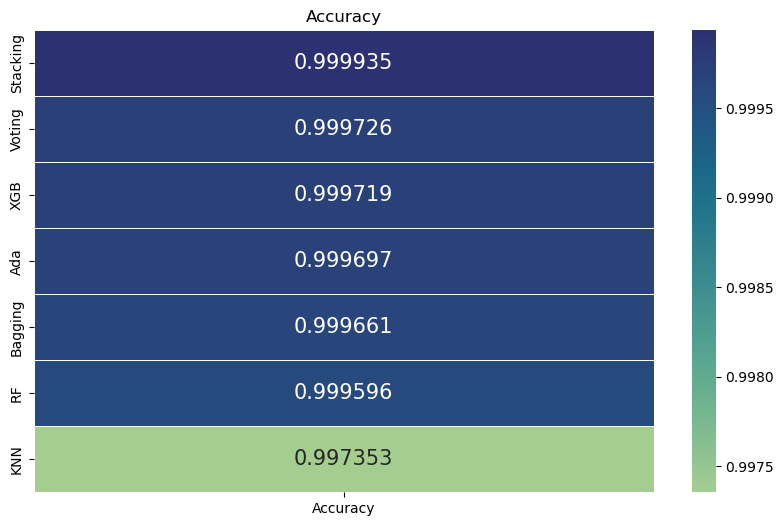

c:\Users\barto\Desktop\Repos\MachineLearning\Project3\classes_and_functions_p3\custom_functions_classes_p3.py:178: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  valid_series = aggregated_df.loc[metric].replace(['NaN', 'Inf', 'Invalid'], np.nan).dropna()


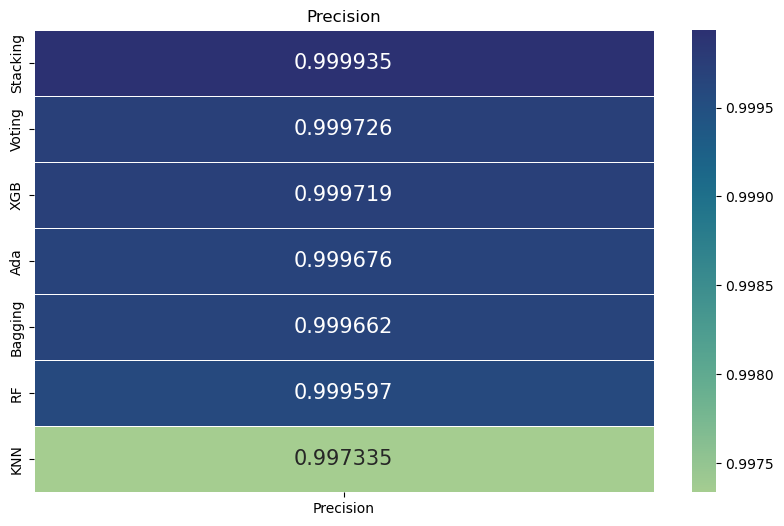

c:\Users\barto\Desktop\Repos\MachineLearning\Project3\classes_and_functions_p3\custom_functions_classes_p3.py:178: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  valid_series = aggregated_df.loc[metric].replace(['NaN', 'Inf', 'Invalid'], np.nan).dropna()


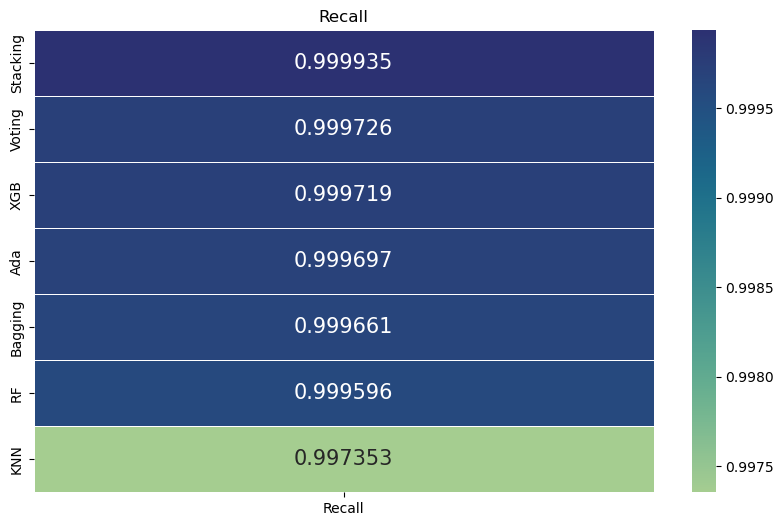

c:\Users\barto\Desktop\Repos\MachineLearning\Project3\classes_and_functions_p3\custom_functions_classes_p3.py:178: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  valid_series = aggregated_df.loc[metric].replace(['NaN', 'Inf', 'Invalid'], np.nan).dropna()


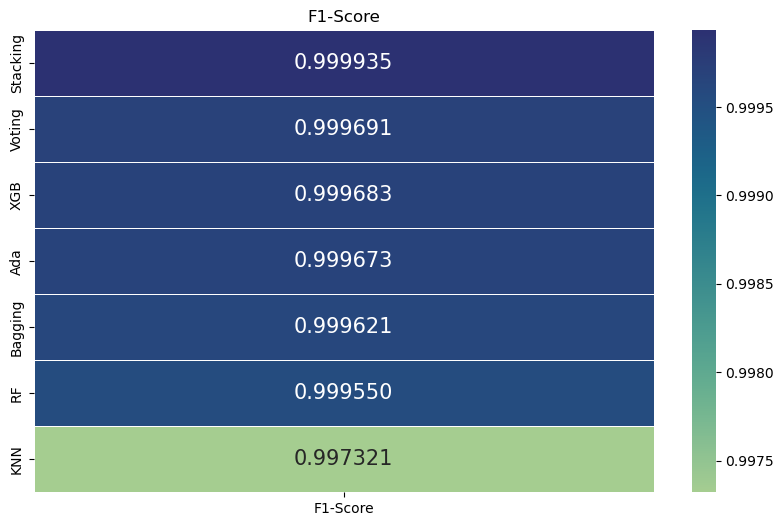

In [46]:
aggregate_metrics_and_create_heatmaps_classification([xgb_metrics, ada_metrics, rf_metrics, knn_metrics, voting_metrics, stacking_metrics, bagging_metrics])